In [1]:
!pip install -q torch==2.8.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all:
!pip install -q transformers accelerate pandas scikit-learn wandb unidecode nltk seaborn tqdm emoji huggingface_hub matplotlib

ERROR: Could not find a version that satisfies the requirement torch==2.8.0 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121, 2.5.0+cu121, 2.5.1+cu121)
ERROR: No matching distribution found for torch==2.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 

In [2]:
import os, re, random, emoji, nltk, torch, warnings
import numpy as np, pandas as pd, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
#WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

nltk.download('punkt')
warnings.filterwarnings("ignore")
login(token= HF_TOKEN)
import wandb
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda


In [3]:
class CFG:
    MODEL_NAME = "vinai/bertweet-base"
    MAX_LEN = 96
    BATCH_SIZE = 32
    NUM_EPOCHS = 10
    LR = 2e-5
    WEIGHT_DECAY = 0.01
    NUM_WORKERS = 2
    SEED = 90210
    WARMUP_RATIO = 0.1
    DROPOUT = 0.2
    R_DROP_ALPHA = 0.3
    LABEL_SMOOTH = 0.1
    GRAD_ACCUM = 1
    FP16 = True


In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(CFG.SEED)

def pre_process_document(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = emoji.demojize(text)
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()


In [5]:
train_df = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/train.csv")
val_df   = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/val.csv")
test_df  = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/test.csv")

train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text']   = val_df['text'].apply(pre_process_document)
test_df['text']  = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label']   = le.transform(val_df['label'])
test_df['label']  = le.transform(test_df['label'])

NUM_CLASSES = train_df['label'].nunique()
CLASS_NAMES = le.classes_
print(f"Detected {NUM_CLASSES} emotion classes: {list(CLASS_NAMES)}")

Detected 6 emotion classes: [0, 1, 2, 3, 4, 5]


In [6]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['text'].values
        self.labels = df['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx]).long()
        enc = self.tokenizer(
            text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'label': label
        }

train_ds = TweetDataset(train_df, tokenizer, CFG.MAX_LEN)
val_ds   = TweetDataset(val_df, tokenizer, CFG.MAX_LEN)
test_ds  = TweetDataset(test_df, tokenizer, CFG.MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,  num_workers=CFG.NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [7]:
class BERTweetClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(CFG.MODEL_NAME)
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        return self.fc(pooled)

def compute_kl_loss(p, q):
    p = F.log_softmax(p, dim=-1)
    q = F.log_softmax(q, dim=-1)
    p_loss = F.kl_div(p, q.exp(), reduction='batchmean')
    q_loss = F.kl_div(q, p.exp(), reduction='batchmean')
    return (p_loss + q_loss) / 2

def label_smoothing_loss(pred, target, smoothing=CFG.LABEL_SMOOTH):
    confidence = 1.0 - smoothing
    logprobs = F.log_softmax(pred, dim=-1)
    nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    return (confidence * nll_loss + smoothing * smooth_loss).mean()

def train_one_epoch(model, loader, optimizer, scheduler, scaler):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        labels = batch['label'].to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            logits1 = model(input_ids, attention_mask)
            logits2 = model(input_ids, attention_mask)
            ce_loss = (label_smoothing_loss(logits1, labels) + label_smoothing_loss(logits2, labels)) / 2
            kl_loss = compute_kl_loss(logits1, logits2)
            loss = ce_loss + (CFG.R_DROP_ALPHA * kl_loss)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def eval_model(model, loader, return_preds=False):
    model.eval()
    preds, labels = [], []
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        outputs = model(input_ids, attention_mask)
        preds.extend(outputs.argmax(dim=-1).cpu().numpy())
        labels.extend(batch['label'].numpy())
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average='weighted')
    if return_preds:
        return acc, f1, preds, labels
    return acc, f1

In [8]:
model = BERTweetClassifier(NUM_CLASSES).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
num_training_steps = len(train_loader) * CFG.NUM_EPOCHS
num_warmup_steps = int(CFG.WARMUP_RATIO * num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
scaler = torch.cuda.amp.GradScaler(enabled=CFG.FP16)

best_f1 = 0.0
for epoch in range(CFG.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{CFG.NUM_EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, scaler)
    val_acc, val_f1 = eval_model(model, val_loader)
    print(f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "/kaggle/working/best_model.pt")


2025-10-29 19:12:22.070849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761765142.261294      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761765142.317950      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]


Epoch 1/10



Training: 100%|██████████| 1629/1629 [07:33<00:00,  4.07it/s]


Train Loss: 0.9062 | Val Acc: 0.9627 | Val F1: 0.9626

Epoch 2/10


Train Loss: 0.4913 | Val Acc: 0.9688 | Val F1: 0.9688

Epoch 3/10


Train Loss: 0.4776 | Val Acc: 0.9687 | Val F1: 0.9686

Epoch 4/10


Train Loss: 0.4716 | Val Acc: 0.9691 | Val F1: 0.9690

Epoch 5/10


Train Loss: 0.4681 | Val Acc: 0.9694 | Val F1: 0.9693

Epoch 6/10


Train Loss: 0.4647 | Val Acc: 0.9714 | Val F1: 0.9713

Epoch 7/10


Train Loss: 0.4616 | Val Acc: 0.9696 | Val F1: 0.9694

Epoch 8/10


Train Loss: 0.4585 | Val Acc: 0.9696 | Val F1: 0.9696

Epoch 9/10


Train Loss: 0.4548 | Val Acc: 0.9695 | Val F1: 0.9694

Epoch 10/10


Train Loss: 0.4521 | Val Acc: 0.9694 | Val F1: 0.9693


In [9]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pt"))
test_acc, test_f1, preds, labels = eval_model(model, test_loader, return_preds=True)
print(f"\nTest Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}")
print("Model saved to /kaggle/working/best_model.pt")


Test Accuracy: 0.9711 | Test F1: 0.9711
Model saved to /kaggle/working/best_model.pt


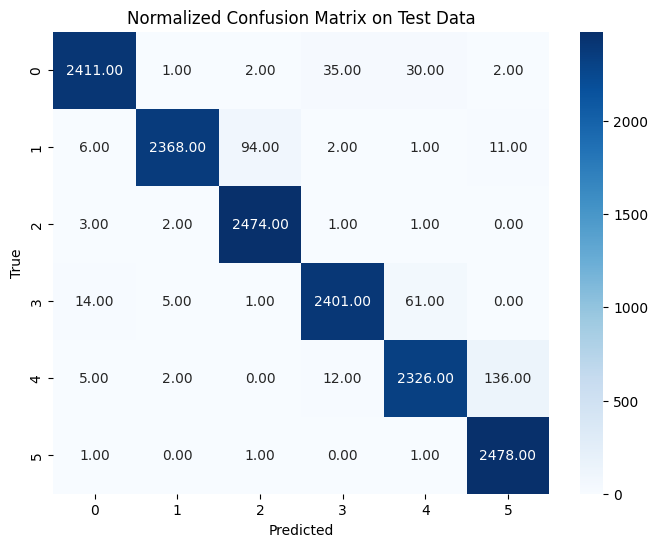

In [10]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix on Test Data")
plt.show()